# CNN for `complete` dataset

### Things to keep in mind

- (only with colab) to maintain the runtime even after many hours of connection we can open the console (f12) and copy-paste this



```
function ClickConnect(){
    console.log("Working"); 
    document.querySelector("#comments").click() 
}
setInterval(ClickConnect,60000)
```

Attention: sometimes it asks whether you're human or not via captcha. 

- remember to add each function to the utils' scripts after its finalization
- to connect to VM GCE use the following credentials 


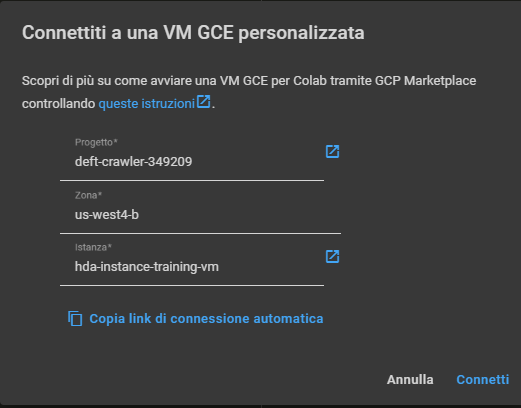

### Custom Functions

In [ ]:
def plot_history(history, model = None, save_path = None, validation = True, data_type = None):
    
    """

    Plots accuracy/loss for training/validation set as a function of the epochs.

    Parameters:
      history: Training history of model.
      model: model onject.
      filename: Name of the file.

    """
    
    fig, axs = plt.subplots(2)

    # Create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    if validation: 
        axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation of {} - {} data".format(model._name if model else "Unspecified", data_type if model else "Unspecified"))

    # Create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    if validation:
        axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation {} - {} data".format(model._name if model else "Unspecified", data_type if model else "Unspecified"))

    if save_path: 
        plt.savefig(save_path)

    plt.show()
    
def _normalize(x, output_range = (-1,1), abs_norm = False, std = False):
    
    """
    This function applies a normalization of the features. By default does [-1,1]-Normalization, but it can be adapted to
    every desired range. 
    
    Parameters:
        
        x (numpy array): Feature data. Recall that 
        
        output_range (tuple): Tuple containing, respectively, the minimum value of the features after the 
        transformation and the maximum one (min_value, max_value) 
        
        abs_norm (bool): Boolean value. If True means that normalization is done extracting the min and the max values
        over all dimensions. 
        If False, then normalize w.r.t. the features (so it considers the individual variability of each mel-coefficient).
        The former does normalize in way that preserves the exact information content of the data meanwhile, the latter does normalize in way
        that gives the same relevance to each feature (mel-coefficient). 
        
        std (bool): Boolean value. If True does perform standardization with variance correction, otherwise performs standardization. 
        
    """
    # if std: 
        # mu, sigma = 
        
    if abs_norm:
    
        new_max, old_max = np.array([output_range[1],  np.max(x)])-5e-5
        new_min, old_min = np.array([output_range[0],  np.min(x)])+5e-5
        return ((new_max-new_min)/(old_max-old_min))*(x-old_max) + new_max
    
    else: 
        
        old_max_array, old_min_array = np.max(np.max(x, axis = 2), axis = 0), np.min(np.min(x, axis = 2), axis = 0)
        old_max_matrix, old_min_matrix = np.outer(old_max_array, np.ones((1, x.shape[-1])))+5e-5 , np.outer(old_min_array, np.ones((1, x.shape[-1])))-5e-5
        new_max_matrix, new_min_matrix = np.ones((x.shape[-2], x.shape[-1]))*output_range[1], np.ones((x.shape[-2], x.shape[-1]))*output_range[0]
        return ((new_max_matrix-new_min_matrix)/(old_max_matrix-old_min_matrix))*(x-old_max_matrix) + new_max_matrix 

def plot_confusion_matrix(cm, labels, title = "Confusion Matrix", normalize = False, display_metrics = True, figsize = (7,7)):
    """
    This function makes the plot of a given a sklearn confusion matrix (cm)
    
    Parameters: 

    cm (np.array): confusion matrix from sklearn.metrics.confusion_matrix
    labels (dict): a dictionary containing the name of the categories and the corresponding labels
    title (string): title of the output plot 
    normalize (bool): If False, plot the raw numbers
               If True, plot the proportions
    display_metrics (bool): if True, does show the accuracy and the misclassification metrics of the model
               
        
    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(figsize[0],figsize[1]))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(f'{title}\n', fontsize=13)

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45, fontsize=12)
        plt.yticks(tick_marks, labels, fontsize=12)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 10 if normalize else cm.max() / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        if normalize:

            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
        else:

            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.tight_layout()
    if display_metrics:
        plt.ylabel('True label', fontsize=10)
        plt.xlabel('\nPredicted label\naccuracy={:0.4f} - misclass={:0.4f}'.format(accuracy, misclass), fontsize=10)
    plt.show()

def set_dark_theme(figsize=(8, 8), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

def envelope_coefficients(x):
    return x[:, :13, :]

# Libraries

In [ ]:
!pip install python_speech_features keras-tuner pydub -q

     |████████████████████████████████| 133 kB 5.3 MB/s 


In [ ]:
import os 
import sys
import json  
import time
from   datetime                import date
  
import pandas                  as pd
import numpy                   as np 
import matplotlib.pyplot       as plt  
import seaborn                 as sns

from   sklearn.metrics         import confusion_matrix

import tensorflow              as tf
from   tensorflow              import keras
from   tensorflow.keras        import layers, models, Input, initializers, metrics
from   tensorflow.keras.layers import Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from   tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from   tensorflow.keras.models import Model, Sequential
import keras_tuner             as kt

from   scipy.io                import wavfile
from   python_speech_features  import mfcc, logfbank
import wave 
import librosa 

import itertools
import cProfile
from   IPython                 import display

# Configuration 

In [43]:
colab = input("Are you using colab's GPU? y/n:   ").lower()
user = input("Are you Fra or Fede? Fra/Fede:   ").lower()

if colab == "y":
    
    cloud = "n"
    
    from google.colab import drive                                                                                   # Colab and Drive Libraries

    if user == "fra":
        drive.mount('/content/drive')                                                                                # To attempt to forcibly remount -> force_remount=True
        FRA_PATH, FEDE_PATH = "/content/drive/MyDrive/University/HDA", "/content/drive/MyDrive/HDA_Project/project"  # Paths
        os.chdir(FRA_PATH)                                                                                           # Setting the working directory
    else: 
        os.chdir(FEDE_PATH)

    sys.path.append('./src/features')
    sys.path.append('./src/data')
    sys.path.append('./src/models')
    
    import feature_utils as fs
    import data_utils as ds
    import training_utils as ts

else: 

    cloud = input("Are you using google cloud services? y/n:    ").lower() 
    access = input("Did you erase cloud's storage content or creating new buckets of memory? y/n:   ").lower()

    if cloud == "y" and access == "y":
  
        import uuid                                                                                                  # Import universal unique identifier library
        bucket_name = "hda-project-bucket" + str(uuid.uuid1())                                                       # Creating a unique id name for the "bucket" of data in the cloud      
        project_id = 'deft-crawler-349209'                                                                           # Id name of the cloud project 
        start_time = time.time()                                                                                     # Starting the timer
    
    if input("Are you in local? y/n   ").lower() == "y":
        
        FRA_PATH = FEDE_PATH = "../" 
        
        sys.path.append('../src/features')
        sys.path.append('../src/data')
        sys.path.append('../src/models')

        import feature_utils as fs
        import data_utils as ds
        import training_utils as ts
        import constants
        
    else:
        
        sys.path.append('./src/features')
        sys.path.append('./src/data')
        sys.path.append('./src/models')

        import feature_utils as fs
        import data_utils as ds
        import training_utils as ts
        import constants

Are you using colab's GPU? y/n:   y
Are you Fra or Fede? Fra/Fede:   Fra
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Graphic Settings

In [ ]:
set_dark_theme() if input("Are you in dark mode? y/n:   ").lower() == "y" else print("Hurts your eyes")

Are you in dark mode? y/n:   y


#### GPU checking - only works with colab

In [ ]:
tf.config.list_physical_devices('GPU') # Checking for presence of GPU devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!nvidia-smi

Sat Jun 11 17:34:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Checking working directory and content

In [ ]:
!pwd 
!dir

/content/drive/MyDrive/University/HDA
data	   model.png  processing_pipeline.drawio.svg  results	     utilities
documents  models     README.md			      src
LICENSE    notebooks  requirements.txt		      useful\ books


# Transferring data from Google Cloud Storage to Colab memory with google CLI - Only using Cloud Engine Services for the first time


In [ ]:
if access == "n": 
    bucket_name = "hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002" # Using r the "bucket" of data in the cloud      
project_id = 'deft-crawler-349209'                                         # Id name of the cloud project 

In [ ]:
from google.colab import auth
auth.authenticate_user()                                                   # to autenticate on GCE
!gcloud config set project {project_id}                                     # to "import" the project

Updated property [core/project].


If you run gsutil <code>ls</code> without URLs, it lists all of the Cloud Storage buckets under your default project ID (or all of the Cloud Storage buckets under the project you specify with the -p flag). 

Listing all the existing buckets: 

In [ ]:
!gsutil ls

gs://hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002/


Copying the content of the bucket in a temporary folder on colab 

In [ ]:
!gsutil -m cp -r gs://{bucket_name} /tmp

Copying gs://hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002/X_test_sample.npy...
Copying gs://hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002/X_test.npy...
Copying gs://hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002/X_train.npy...
Copying gs://hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002/X_train_sample.npy...
Copying gs://hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002/X_valid_sample.npy...
Copying gs://hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002/y_test.npy...
Copying gs://hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002/y_train.npy...
Copying gs://hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002/X_valid.npy...
Copying gs://hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002/y_test_sample.npy...
Copying gs://hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002/y_train_sample.npy...
Copying gs://hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002/y_valid.npy...
Copying gs://hda-project-bucket0058fc9a-cc78-11ec-8655-0

Access to the bucket on the Google Cloud Services Storage Page 

In [ ]:
#@markdown Al termine del caricamento, i dati verranno visualizzati nel browser Cloud Console Storage per il tuo progetto:
print('https://console.cloud.google.com/storage/browser?project=' + project_id)

https://console.cloud.google.com/storage/browser?project=deft-crawler-349209


# Filepaths

In [ ]:
# Defining Filepaths 
if colab == "y": 

    # Destination Path of .npy file
    BINARIES_PATH = "./data/binaries/filtered/" 

else: 

    DATASET_PATH = "../data/raw/dataset_v2_complete/"
    BINARIES_PATH = "../data/binaries/filtered/" 

if cloud == "y":
    bucket_name = "hda-project-bucket0058fc9a-cc78-11ec-8655-0242ac1c0002" # Using r the "bucket" of data in the cloud      
    project_id = 'deft-crawler-349209'                                         # Id name of the cloud project 
    BINARIES_PATH = "/tmp/" + bucket_name + "/"

## Loading Binaries (Not sampled ones)

In [ ]:
X_train = np.load(BINARIES_PATH + "X_train_complete.npy")
X_valid = np.load(BINARIES_PATH + "X_valid_complete.npy")
X_test = np.load(BINARIES_PATH + "X_test_complete.npy")

y_train = np.load(BINARIES_PATH + "y_train_complete.npy")
y_valid = np.load(BINARIES_PATH + "y_valid_complete.npy")
y_test = np.load(BINARIES_PATH + "y_test_complete.npy")

## 38 secs on cpu time to import from drive
## 27 secs on gpu time to import from drive

## Extracting first 13 dimensions from them

In [ ]:
X_train_envelope, X_valid_envelope, X_test_envelope = envelope_coefficients(X_train), envelope_coefficients(X_valid), envelope_coefficients(X_test)

## Scaling of $\mathbf{X}_{train}$ and $\mathbf{X}_{valid}$

According to [1] make learning easier for the network, the data should have the following characteristics:

- *Take small values* — Typically, most values should be in the 0–1 range.
- *Be homogenous* —All features should take values in roughly the same range.

All properties of the normalization application: $$\large x_{norm}= \frac{x -x_{min}}{x_{max}-x_{min}}$$

Additionally, the following stricter normalization practice is common and can help,
although it isn’t always necessary:

-  Normalize each feature independently to have a mean of 0.
-  Normalize each feature independently to have a standard deviation of 1.

This is called standardization (or Z-normalization): $$\large x_{std}= \frac{x-\bar{x} }{\sqrt{\hat{\sigma_{x}}}}$$

But when dealing with images, standardization **may** weaken the ratios among near pixel values. Making the network more biased a priori, due to the information loss. Because even though they are both linear functions (both can be expressed in the form $y = a + b*x$), only the $0-1$ normalization is a *linear map*, i.e. a function that preserve: 

- **Collinearity**. If three points are collinear before the transformation, they remain collinear afterwards.
- **Parallelism**. If two lines are parallel before the transformation, they remain parallel afterwards. This implies that a grid will remain a grid after the transformation.
- The **Origin**. The origin point will be the origin after the transformation.
- Any other property that is consequence of the ones mentioned above.

**Note**: *Lengths are not preserved, but their ratios are. In addition,* ***angles may or may not be preserved.*** In fact, only the [-1,1] does preserve the ratios among different values before and after transformantion.

Then, our choice is to do both. Probably the choice of the activation function is sensitive to this.


We apply this procedure directly onto the overall dataset (instead of applying onto each sampled subset) to avoid different ranges for each sample (i.e. so different scaling ratios for normalization). 


[1] *Deep Learning with Python, F. Chollet, 2nd edition - 2020*

### Normalization [-1,1]

$$ x_{norm}= \frac{x}{x_{max}-x_{min}}$$


From "Efficient BackProp" [2], features' data should have a zero mean and a stable input distribution (approximately the same variance). This allows the net to learn different features. This also allows for an uneven distribution of the weights' updates.  

Then this property may be satisfied across layers by the type of initialization scheme and activation function. 


[2] *http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf - 1998*

In [ ]:
X_train_norm, X_valid_norm, X_test_norm = _normalize(X_train), _normalize(X_valid), _normalize(X_test)
X_train_norm.shape

(30769, 40, 99)

Notice that to scale each slice of the dataset we're using their max and min.  

#### First 13 dimension of [-1,1] normalized data

In [ ]:
X_train_norm_envelope, X_valid_norm_envelope, X_test_norm_envelope = envelope_coefficients(X_train_norm), envelope_coefficients(X_valid_norm), envelope_coefficients(X_test_norm)
X_train_norm_envelope.shape

(30769, 13, 99)

#### Normalization [-1,1] absolute

In [ ]:
X_train_norm_abs, X_valid_norm_abs, X_test_norm_abs = _normalize(X_train, abs_norm = True), _normalize(X_valid, abs_norm = True), _normalize(X_test, abs_norm = True)
X_train_norm_abs.shape

(30769, 40, 99)

#### First 13 dimensions of [-1,1] absolute normalized data 

In [ ]:
X_train_norm_abs_envelope, X_valid_norm_abs_envelope, X_test_norm_abs_envelope = envelope_coefficients(X_train_norm_abs), envelope_coefficients(X_valid_norm_abs), envelope_coefficients(X_test_norm_abs)
X_train_norm_abs_envelope.shape

(30769, 13, 99)

### Normalization [0-1] 
$$ x_{norm}= \frac{x -x_{min}}{x_{max}-x_{min}}$$

In [ ]:
X_train_norm_nn, X_valid_norm_nn, X_test_norm_nn = _normalize(X_train, output_range=(0,1)), _normalize(X_valid, output_range=(0,1)), _normalize(X_test, output_range=(0,1))
X_train_norm_nn.shape
# nn stands for non-negative (referring to the output range)

(30769, 40, 99)

### Standardization 

In [ ]:
# X_train_std, X_valid_std, X_test_std = 

## Data Sampling 

### Sampling [-1,1]-normalized data

In [ ]:
(X_train_norm_20, y_train_20), (X_train_norm_40, y_train_40), (X_train_norm_60, y_train_60), (X_train_norm_80, y_train_80) = [ds.stratified_sampling(X_train_norm, y_train, num_classes = 10, ratio = ratio) for ratio in [0.2,0.4,0.5,0.8]]
(X_valid_norm_20, y_valid_20), (X_valid_norm_40, y_valid_40), (X_valid_norm_60, y_valid_60), (X_valid_norm_80, y_valid_80) = [ds.stratified_sampling(X_valid_norm, y_valid, num_classes = 10, ratio = ratio) for ratio in [0.2,0.4,0.5,0.8]]
(X_test_norm_20,  y_test_20),  (X_test_norm_40,  y_test_40),  (X_test_norm_60,  y_test_60),  (X_test_norm_80,  y_test_80) = [ds.stratified_sampling(X_test_norm, y_test, num_classes = 10, ratio = ratio) for ratio in [0.2,0.4,0.5,0.8]]

### Sampling [0,1]-normalized data

In [ ]:
X_train_norm_nn_20, X_train_norm_nn_40, X_train_norm_nn_60, X_train_norm_nn_80 = [ds.stratified_sampling(X_train_norm, y_train, num_classes = 10, ratio = ratio)[0] for ratio in [0.2,0.4,0.5,0.8]]
X_valid_norm_nn_20, X_valid_norm_nn_40, X_valid_norm_nn_60, X_valid_norm_nn_80 = [ds.stratified_sampling(X_valid_norm, y_valid, num_classes = 10, ratio = ratio)[0] for ratio in [0.2,0.4,0.5,0.8]]
X_test_norm_nn_20, X_test_norm_nn_40, X_test_norm_nn_60, X_test_norm_nn_80 = [ds.stratified_sampling(X_test_norm, y_test, num_classes = 10, ratio = ratio)[0] for ratio in [0.2,0.4,0.5,0.8]]

### Saving Binaries 

In [ ]:
# Save overwrites existent homonym binary files

# [-1,1] normalized

np.save(BINARIES_PATH + "X_train_norm_20",  X_train_norm_20)
np.save(BINARIES_PATH + "X_train_norm_40",  X_train_norm_40)
np.save(BINARIES_PATH + "X_train_norm_60",  X_train_norm_60)
np.save(BINARIES_PATH + "X_train_norm_80",  X_train_norm_80)

np.save(BINARIES_PATH + "X_valid_norm_20",  X_valid_norm_20)
np.save(BINARIES_PATH + "X_valid_norm_40",  X_valid_norm_40)
np.save(BINARIES_PATH + "X_valid_norm_60",  X_valid_norm_60)
np.save(BINARIES_PATH + "X_valid_norm_80",  X_valid_norm_80)

np.save(BINARIES_PATH + "X_test_norm_20",  X_test_norm_20)
np.save(BINARIES_PATH + "X_test_norm_40",  X_test_norm_40)
np.save(BINARIES_PATH + "X_test_norm_60",  X_test_norm_60)
np.save(BINARIES_PATH + "X_test_norm_80",  X_test_norm_80)

# [0,1] normalized

np.save(BINARIES_PATH + "X_train_norm_nn_20",  X_train_norm_nn_20)
np.save(BINARIES_PATH + "X_train_norm_nn_40",  X_train_norm_nn_40)
np.save(BINARIES_PATH + "X_train_norm_nn_60",  X_train_norm_nn_60)
np.save(BINARIES_PATH + "X_train_norm_nn_80",  X_train_norm_nn_80)

np.save(BINARIES_PATH + "X_valid_norm_nn_20",  X_valid_norm_nn_20)
np.save(BINARIES_PATH + "X_valid_norm_nn_40",  X_valid_norm_nn_40)
np.save(BINARIES_PATH + "X_valid_norm_nn_60",  X_valid_norm_nn_60)
np.save(BINARIES_PATH + "X_valid_norm_nn_80",  X_valid_norm_nn_80)

np.save(BINARIES_PATH + "X_test_norm_nn_20",  X_test_norm_nn_20)
np.save(BINARIES_PATH + "X_test_norm_nn_40",  X_test_norm_nn_40)
np.save(BINARIES_PATH + "X_test_norm_nn_60",  X_test_norm_nn_60)
np.save(BINARIES_PATH + "X_test_norm_nn_80",  X_test_norm_nn_80)

# Sampled ys

np.save(BINARIES_PATH + "y_test_20",  y_test_20)
np.save(BINARIES_PATH + "y_test_40",  y_test_40)
np.save(BINARIES_PATH + "y_test_60",  y_test_60)
np.save(BINARIES_PATH + "y_test_80",  y_test_80)

### Load Binaries

In [ ]:
# load binary files

# [-1,1] normalized

np.load(BINARIES_PATH + "X_train_norm_20.npy")
np.load(BINARIES_PATH + "X_train_norm_40.npy")
np.load(BINARIES_PATH + "X_train_norm_60.npy")
np.load(BINARIES_PATH + "X_train_norm_80.npy")

np.load(BINARIES_PATH + "X_valid_norm_20.npy")
np.load(BINARIES_PATH + "X_valid_norm_40.npy")
np.load(BINARIES_PATH + "X_valid_norm_60.npy")
np.load(BINARIES_PATH + "X_valid_norm_80.npy")

np.load(BINARIES_PATH + "X_test_norm_20.npy")
np.load(BINARIES_PATH + "X_test_norm_40.npy")
np.load(BINARIES_PATH + "X_test_norm_60.npy")
np.load(BINARIES_PATH + "X_test_norm_80.npy")

# [0,1] normalized

np.load(BINARIES_PATH + "X_train_norm_nn_20.npy")
np.load(BINARIES_PATH + "X_train_norm_nn_40.npy")
np.load(BINARIES_PATH + "X_train_norm_nn_60.npy")
np.load(BINARIES_PATH + "X_train_norm_nn_80.npy")
np.load(BINARIES_PATH + "X_valid_norm_nn_20.npy")
np.load(BINARIES_PATH + "X_valid_norm_nn_40.npy")
np.load(BINARIES_PATH + "X_valid_norm_nn_60.npy")
np.load(BINARIES_PATH + "X_valid_norm_nn_80.npy")

np.load(BINARIES_PATH + "X_test_norm_nn_20.npy")
np.load(BINARIES_PATH + "X_test_norm_nn_40.npy")
np.load(BINARIES_PATH + "X_test_norm_nn_60.npy")
np.load(BINARIES_PATH + "X_test_norm_nn_80.npy")

# Sampled ys

np.load(BINARIES_PATH + "y_test_20.npy")
np.load(BINARIES_PATH + "y_test_40.npy")
np.load(BINARIES_PATH + "y_test_60.npy")
np.load(BINARIES_PATH + "y_test_80.npy")

---
---

# Convolutional Neural Network Architecture on the `complete` dataset

The following training pipeline is made as follows:   

1. Selection of the best model $\mathcal{M}^*$ from the 5 best performing models $\mathcal{M}_{0,1,2,3,4}$ obtained from previous fit on `reduced` dataset.

2. Training on the `complete dataset` from the beginning. Finding the optimal epoch for training $$\mathcal{E}^* = \underset{i \in {1,\dots,100}}{\operatorname{max}} {\mathcal{L}_{\mathcal{V}}(\mathbf{y},\hat{\mathbf{y}})}$$


3. Re-train the model in both training $\mathcal{T}_R$ and validation $\mathcal{V}$ sets and obtain the test set $\mathcal{T}$ performance. 
4. Select the best test performing model $\mathcal{M}^* = \underset{i \in {0,1,2,3,4}}{\operatorname{max}} \underset{\mathcal{T}}{\operatorname{accuracy}}(\mathcal{M}_i$) and computing its confusion matrix $\mathbb{M}_{\mathcal{M}}$.

    



# CNN 1`Conv2D`+ 1 `Dense` - architecture

## 1. Selection of the best model $\mathcal{M}^*$ from the 5 best performing models $\mathcal{M}_{0,1,2,3,4}$ obtained from previous fit on `reduced` dataset

### Loading Best Model

In [ ]:
best_models = []

for i in range(5):
    model =  models.load_model(FRA_PATH + f"/models/1_conv2d_1_dense_models/best_1_conv2d_1_dense_model_no_{i}.h5")
    best_models += [model]
    print(f"Number of paramters in the model: {model.count_params()}")

Number of paramters in the model: 241034
Number of paramters in the model: 117370
Number of paramters in the model: 75962
Number of paramters in the model: 241034
Number of paramters in the model: 152938


In [ ]:
best_1_conv2d_1_dense_model = best_models[3]
best_1_conv2d_1_dense_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 13, 99, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 90, 64)         6464      
_________________________________________________________________
dropout_12 (Dropout)         (None, 4, 90, 64)         0         
_________________________________________________________________
dense_12 (Dense)             (None, 4, 90, 64)         4160      
_________________________________________________________________
dropout_13 (Dropout)         (None, 4, 90, 64)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 23040)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2304

In [ ]:
del best_models

In [ ]:
best_1_conv2d_1_dense_model.get_config()

{'name': 'model_6',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 13, 99, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_7'},
   'name': 'input_7',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d_6',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (10, 10),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d_6',
   'inbound_nodes': [[['input_7', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config': {'n

## 2. Training on the `complete dataset` from the beginning

In [ ]:
def cnn_architecture_all_classes(name = None, input_shape = (13,99,1), num_classes=35):

    # ---------------------------------------------
    # Declare Model's Architecture - Functional API 
    # ---------------------------------------------    

    inputs = keras.Input(shape = input_shape)

    x = layers.Conv2D(filters = 64, 
                      kernel_size = (10,10), 
                      strides = (1,1), 
                      padding = "valid", 
                      activation = "relu", 
                      kernel_initializer = tf.keras.initializers.HeNormal())(inputs)
    
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(64, 
                     activation = "relu",
                     kernel_initializer = tf.keras.initializers.HeNormal())(x)
    
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)

    outputs = layers.Dense(num_classes, activation = "softmax")(x)
    
    # ----------------
    # Define the Model 
    # ----------------

    model = keras.Model(inputs = inputs, outputs = outputs, name = name)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    

    return model

### Keras' Learning Features 

In [ ]:
callbacks = [
    
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  mode="min",
                                  patience=10,
                                  verbose=1),
    
    keras.callbacks.TensorBoard("../tb_logs")
]

### Build the model

In [ ]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Create network
model = cnn_architecture_all_classes(name = "best_1_conv2d_1_dense_complete")
model.summary()

Model: "best_1_conv2d_1_dense_complete"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 13, 99, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 90, 64)         6464      
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 90, 64)         0         
_________________________________________________________________
dense_4 (Dense)              (None, 4, 90, 64)         4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 90, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 23040)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 

In [ ]:
model.get_config()

{'name': 'best_1_conv2d_1_dense_complete',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 13, 99, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_3'},
   'name': 'input_3',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d_2',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (10, 10),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d_2',
   'inbound_nodes': [[['input_3', 0, 0, {}]]]},
  {'class_name': 'Dro

### Training Phase

In [ ]:
# Train model

history = model.fit(X_train_envelope,
                    y_train,
                    epochs=100,
                    batch_size=128,
                    validation_data=(X_valid_envelope, y_valid),
                    callbacks=callbacks)

Insert the type of data on which the network was trained:   envelope un-scaled complete


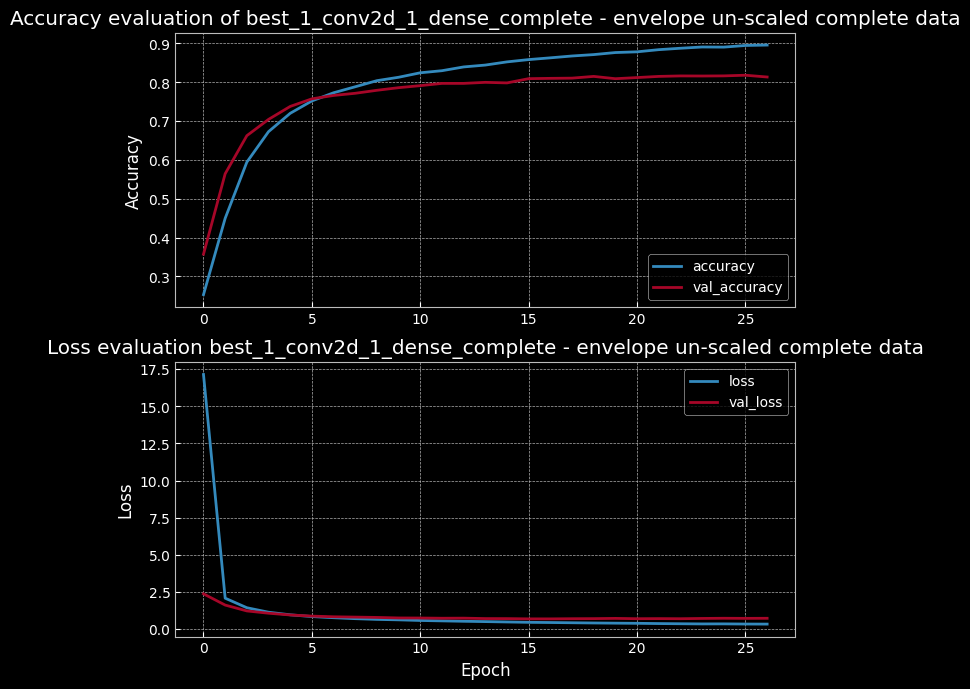

Best epoch: 17


In [ ]:
plot_history(history, model, data_type = input("Insert the type of data on which the network was trained:  "))

val_loss_per_epoch = history.history["val_loss"]

best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1

print(f"Best epoch: {best_epoch}")

### Tensorboard Visualization of all trials for `1Conv2D`+`1Dense`

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ../tb_logs

## 3. Re-train the model in both training $\mathcal{T}_R$ and validation $\mathcal{V}$ sets and obtain the test set $\mathcal{T}$ performance. 

In [ ]:
history = model.fit(
     np.concatenate((X_train_envelope, X_valid_envelope), axis=0),  np.concatenate((y_train, y_valid), axis=0),
     batch_size=128,
     epochs=int(best_epoch * 1.12))

Epoch 1/19
667/667 [==============================] - 66s 99ms/step - loss: 0.4223 - accuracy: 0.8790
Epoch 2/19
667/667 [==============================] - 73s 110ms/step - loss: 0.3674 - accuracy: 0.8910
Epoch 3/19
667/667 [==============================] - 74s 111ms/step - loss: 0.3586 - accuracy: 0.8927
Epoch 4/19
667/667 [==============================] - 75s 113ms/step - loss: 0.3492 - accuracy: 0.8947
Epoch 5/19
667/667 [==============================] - 76s 114ms/step - loss: 0.3365 - accuracy: 0.8977
Epoch 6/19
667/667 [==============================] - 83s 124ms/step - loss: 0.3368 - accuracy: 0.8966
Epoch 7/19
667/667 [==============================] - 76s 114ms/step - loss: 0.3272 - accuracy: 0.9006
Epoch 8/19
667/667 [==============================] - 76s 115ms/step - loss: 0.3139 - accuracy: 0.9047
Epoch 9/19
667/667 [==============================] - 75s 113ms/step - loss: 0.3216 - accuracy: 0.9034
Epoch 10/19
667/667 [==============================] - 80s 120ms/step - lo

### Test Error

In [ ]:
model.evaluate(X_test_envelope, y_test)

316/316 [==============================] - 1s 4ms/step - loss: 0.9661 - accuracy: 0.7883


[0.966069221496582, 0.7882574796676636]

### Confusion Matrix $\mathbb{M}_{\mathcal{M}^*}$

In [ ]:
y_pred = model.predict(X_test_envelope)
y_pred.shape

(10083, 35)

In [ ]:
y_pred = model.predict(X_test_envelope)
matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))

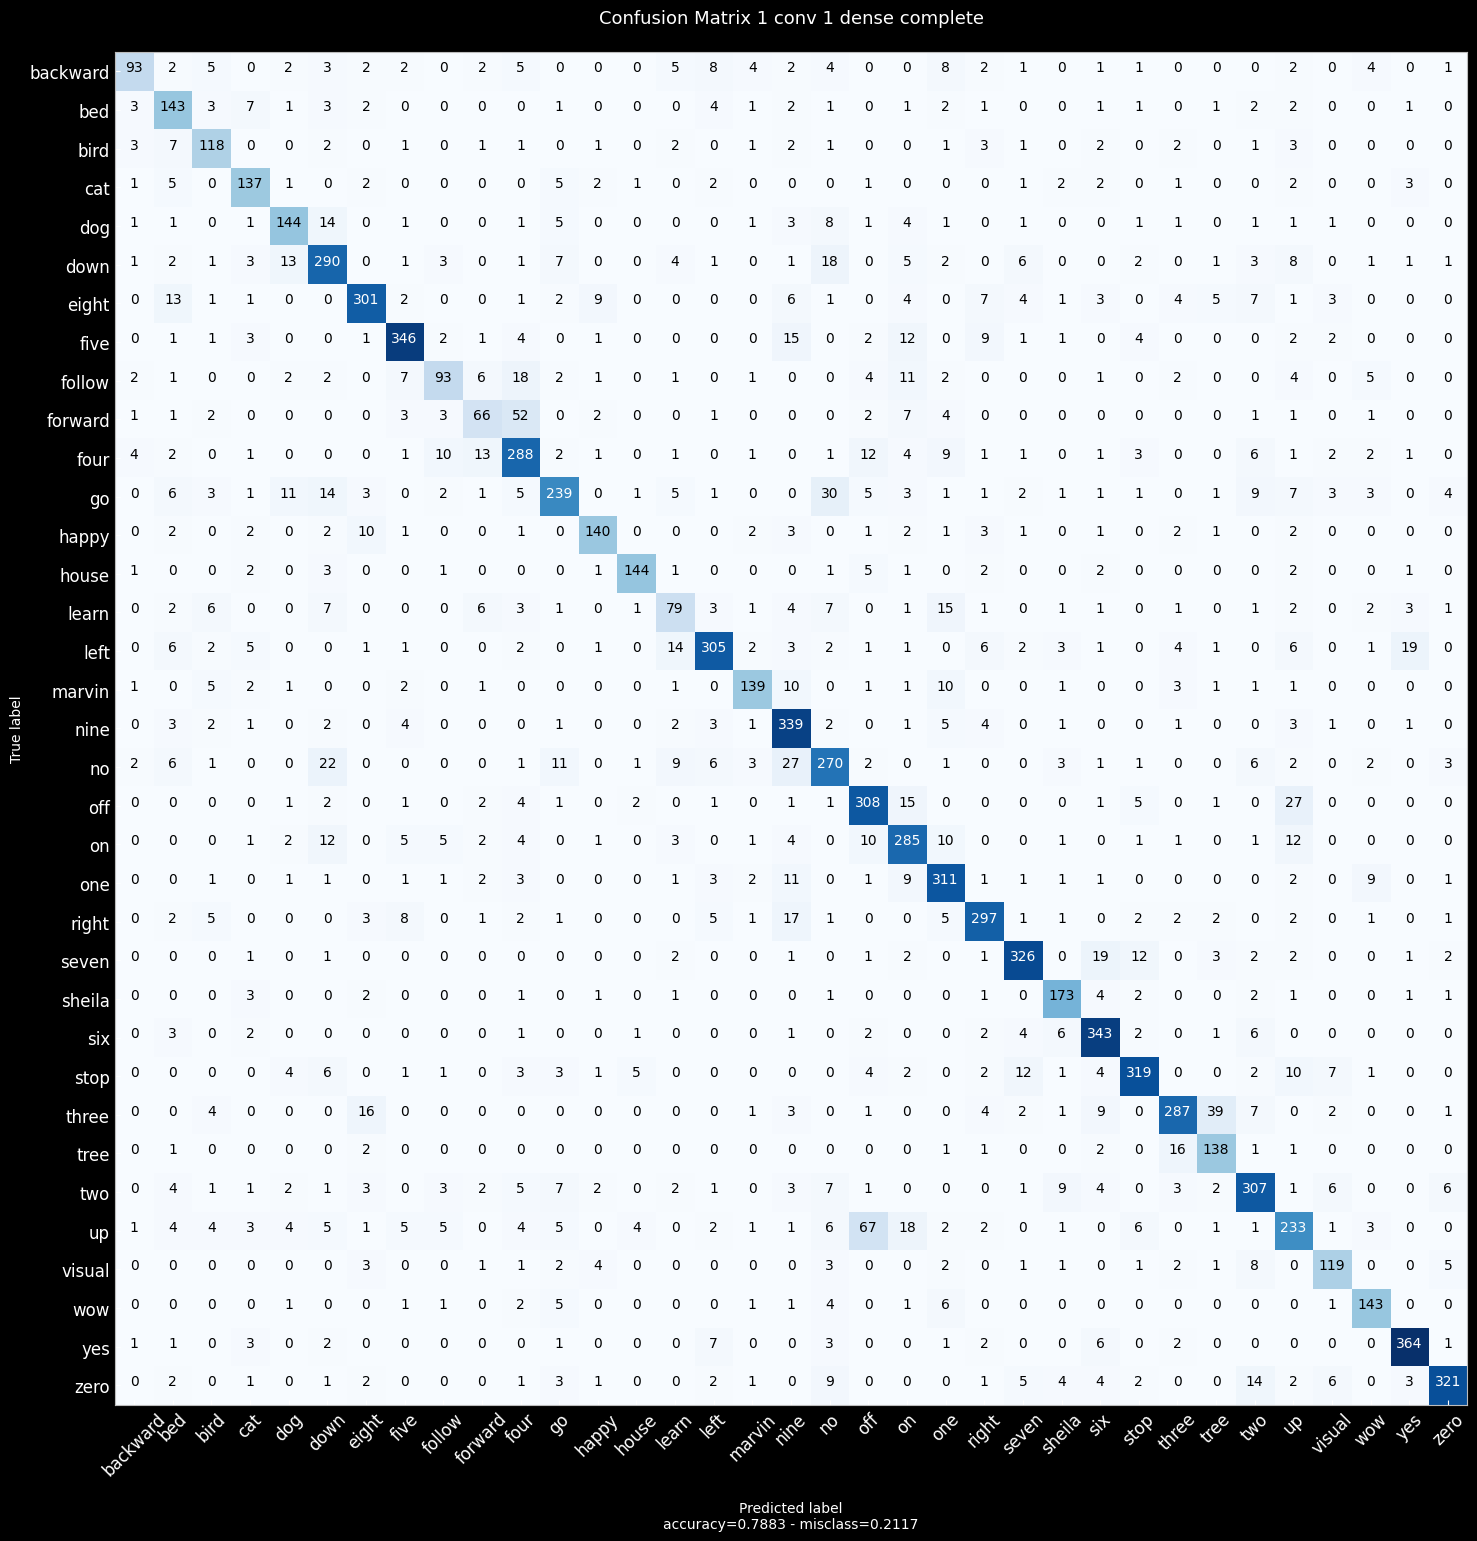

In [ ]:
plot_confusion_matrix(matrix,
                      constants.labels_35_classes, 
                      title = "Confusion Matrix 1 conv 1 dense complete",
                      figsize = (15,15))

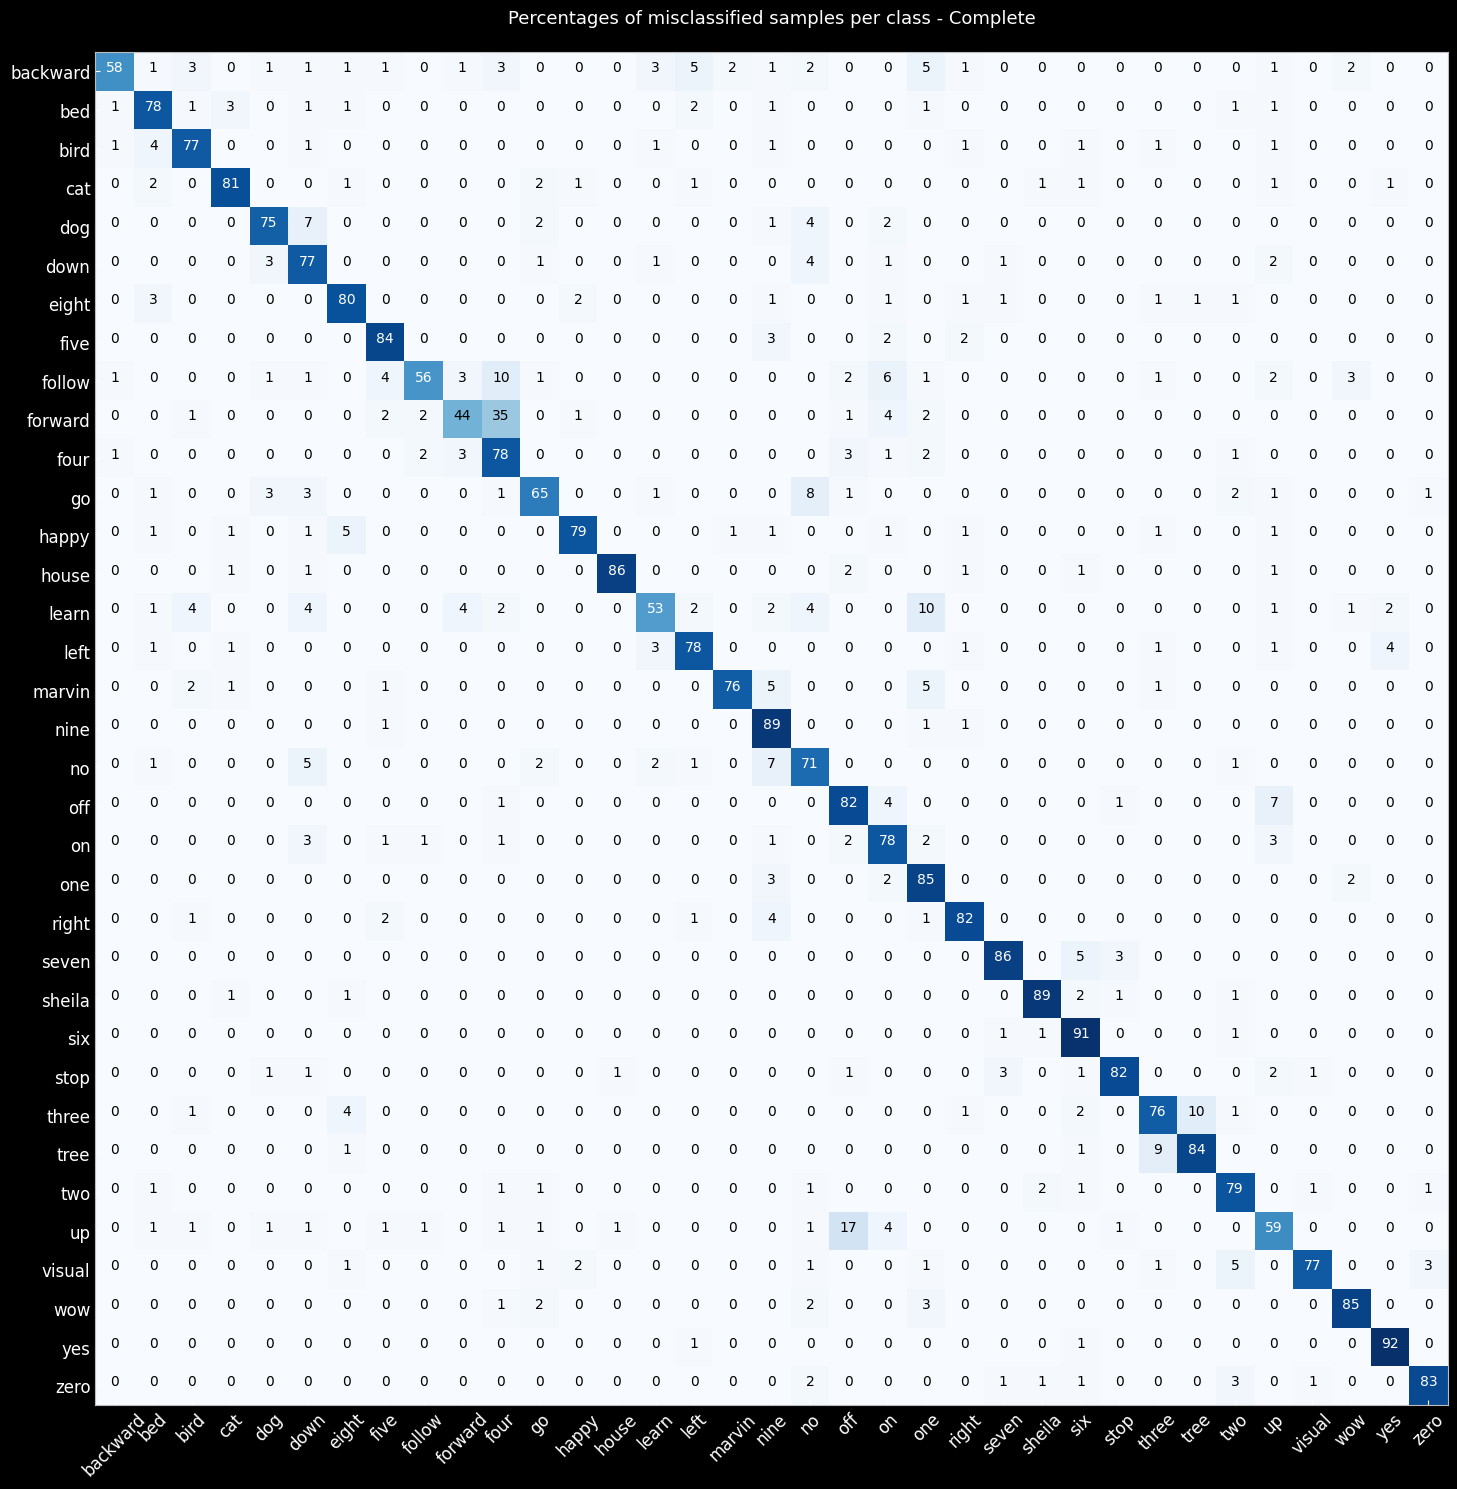

In [ ]:
percentages_misclassified_samples = np.ones_like(matrix)

sums = np.sum(matrix, axis = 1)

for i in range(matrix.shape[0]):
    percentages_misclassified_samples[i] = matrix[i] / sums[i] * 100

# percentages_misclassified_samples
plot_confusion_matrix(percentages_misclassified_samples, 
                      constants.labels_35_classes, 
                      title = "Percentages of misclassified samples per class - Complete", 
                      display_metrics = False,
                      figsize = (15,15))

### Prediction Time of $\mathcal{M}^*$

In [17]:
starts = np.empty((len(X_test_envelope), ))
ends = np.empty((len(X_test_envelope), ))

In [18]:
for i in range(len(X_test_envelope)):

    a = np.array([X_test_envelope[i]])

    starts[i] = time.time()
    a = np.argmax(model.predict(a),1)
    ends[i] = time.time()

average = sum(ends-starts)/len(X_test_envelope)

print("Average single prediction time (ms):", 1000*average)

Average single prediction time (ms): 42.48654500697798


### Saving model

In [ ]:
model.save('../models/best_1_conv2d_1_dense_complete_model.h5')

# CNN 1`Conv2D`+ 1 `Dense` - architecture

## 1. Selection of the best model $\mathcal{M}^*$ from the 10 best performing models $\mathcal{M}_{0,1,2,3,...,9}$ obtained from previous fit on `reduced` dataset

### Loading Best Models

In [28]:
best_models = []

for i in range(10):
    model =  models.load_model(FRA_PATH + f"/models/m_conv2d_n_dense_models/best_flexible_cnn_architecture_model_no_{i}.h5")
    best_models += [model]
    print(f"Number of paramters in the model: {model.count_params()}")

Number of paramters in the model: 701306
Number of paramters in the model: 1607290
Number of paramters in the model: 701306
Number of paramters in the model: 2800970
Number of paramters in the model: 1077418
Number of paramters in the model: 195882
Number of paramters in the model: 2800970
Number of paramters in the model: 1607290
Number of paramters in the model: 2800970
Number of paramters in the model: 582282


In [29]:
best_m_conv2d_n_dense_model = best_models[5]
best_m_conv2d_n_dense_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 13, 99, 1)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 7, 50, 48)         2400      
                                                                 
 dropout_34 (Dropout)        (None, 7, 50, 48)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 25, 48)         112944    
                                                                 
 dropout_35 (Dropout)        (None, 4, 25, 48)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 2, 13, 32)         75296     
                                                                 
 dropout_36 (Dropout)        (None, 2, 13, 32)         0   

In [30]:
del best_models

In [31]:
best_m_conv2d_n_dense_model.get_config()

{'input_layers': [['input_9', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 13, 99, 1),
    'dtype': 'float32',
    'name': 'input_9',
    'ragged': False,
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_9'},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'dtype': 'float32',
    'filters': 48,
    'groups': 1,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (7, 7),
    'name': 'conv2d_25',
    'padding': 'same',
    'strides': (2, 2),
    'trainable': True,
    'use_bias': True},
   'inbound_nodes': [[['input_9', 0, 0, {}]]],
   'name': 'conv2d_25'},
  {'class_name': 'Dropout',

## 2. Training on the `complete dataset` from the beginning

In [32]:
def flexible_cnn_architecture_all_classes(name = None, input_shape = (13,99,1), num_classes=35):
    
    # ---------------------------------------------
    # Declare Model's Architecture - Functional API 
    # ---------------------------------------------    

    inputs = keras.Input(shape = input_shape)

    x = layers.Conv2D(filters = 48, 
                      kernel_size = (7,7), 
                      strides = (2,2), 
                      padding = "same", 
                      activation = "relu", 
                      kernel_initializer = tf.keras.initializers.HeNormal())(inputs)
    
    x = layers.Dropout(0.1)(x)

    x = layers.Conv2D(filters = 48, 
                      kernel_size = (7,7), 
                      strides = (2,2), 
                      padding = "same", 
                      activation = "relu", 
                      kernel_initializer = tf.keras.initializers.HeNormal())(inputs)
    
    x = layers.Dropout(0.1)(x)

    x = layers.Conv2D(filters = 32, 
                      kernel_size = (7,7), 
                      strides = (2,2), 
                      padding = "same", 
                      activation = "relu", 
                      kernel_initializer = tf.keras.initializers.HeNormal())(inputs)
    
    x = layers.Dropout(0.1)(x)
    
    x = layers.Dense(64, 
                     activation = "relu",
                     kernel_initializer = tf.keras.initializers.HeNormal())(x)
    
    x = layers.Dropout(0.1)(x)
    
    x = layers.Dense(64, 
                     activation = "relu",
                     kernel_initializer = tf.keras.initializers.HeNormal())(x)
    
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(64, 
                     activation = "relu",
                     kernel_initializer = tf.keras.initializers.HeNormal())(x)
    
    x = layers.Dropout(0.1)(x)
    
    x = layers.Flatten()(x)

    outputs = layers.Dense(num_classes, activation = "softmax")(x)
    
    # ----------------
    # Define the Model 
    # ----------------

    model = keras.Model(inputs = inputs, outputs = outputs, name = name)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    

    return model

### Keras' Learning Features 

In [33]:
callbacks = [
    
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  mode="min",
                                  patience=10,
                                  verbose=1),
    
    keras.callbacks.TensorBoard("../tb_logs")
]

### Build the model

In [34]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Create network
model = flexible_cnn_architecture_all_classes(name = "best_m_conv2d_n_dense_complete")
model.summary()

Model: "best_m_conv2d_n_dense_complete"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 99, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 50, 32)         1600      
                                                                 
 dropout_2 (Dropout)         (None, 7, 50, 32)         0         
                                                                 
 dense (Dense)               (None, 7, 50, 64)         2112      
                                                                 
 dropout_3 (Dropout)         (None, 7, 50, 64)         0         
                                                                 
 dense_1 (Dense)             (None, 7, 50, 64)         4160      
                                                                 
 dropout_4 (Dropout)         (None, 

In [35]:
model.get_config()

{'input_layers': [['input_1', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 13, 99, 1),
    'dtype': 'float32',
    'name': 'input_1',
    'ragged': False,
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_1'},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'dtype': 'float32',
    'filters': 32,
    'groups': 1,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (7, 7),
    'name': 'conv2d_2',
    'padding': 'same',
    'strides': (2, 2),
    'trainable': True,
    'use_bias': True},
   'inbound_nodes': [[['input_1', 0, 0, {}]]],
   'name': 'conv2d_2'},
  {'class_name': 'Dropout',
 

### Training Phase

In [36]:
# Train model

history = model.fit(X_train_envelope,
                    y_train,
                    epochs=100,
                    batch_size=128,
                    validation_data=(X_valid_envelope, y_valid),
                    callbacks=callbacks)

Epoch 1/100
597/597 [==============================] - 11s 15ms/step - loss: 11.4664 - accuracy: 0.2225 - val_loss: 2.1217 - val_accuracy: 0.4237
Epoch 2/100
597/597 [==============================] - 8s 13ms/step - loss: 2.0256 - accuracy: 0.4352 - val_loss: 1.6208 - val_accuracy: 0.5529
Epoch 3/100
597/597 [==============================] - 8s 14ms/step - loss: 1.6231 - accuracy: 0.5421 - val_loss: 1.3379 - val_accuracy: 0.6279
Epoch 4/100
597/597 [==============================] - 8s 14ms/step - loss: 1.3605 - accuracy: 0.6107 - val_loss: 1.1872 - val_accuracy: 0.6718
Epoch 5/100
597/597 [==============================] - 9s 14ms/step - loss: 1.1885 - accuracy: 0.6562 - val_loss: 1.0892 - val_accuracy: 0.6949
Epoch 6/100
597/597 [==============================] - 8s 13ms/step - loss: 1.0444 - accuracy: 0.6943 - val_loss: 1.0256 - val_accuracy: 0.7152
Epoch 7/100
597/597 [==============================] - 8s 13ms/step - loss: 0.9360 - accuracy: 0.7250 - val_loss: 0.9907 - val_accurac

Insert the type of data on which the network was trained:  un-scaled envelope complete


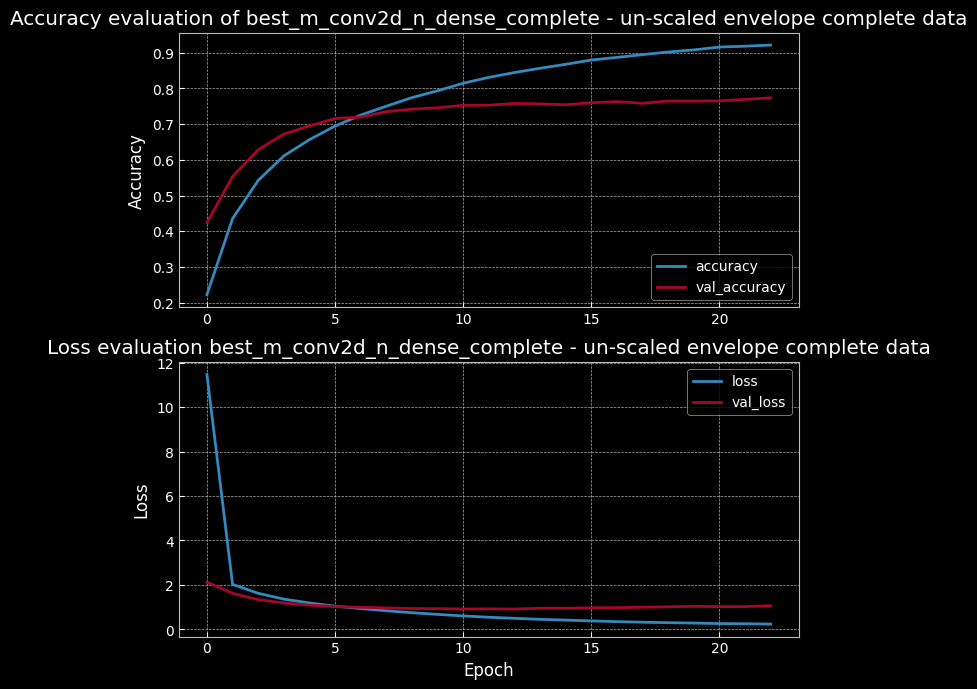

In [37]:
plot_history(history, model, data_type = input("Insert the type of data on which the network was trained:  "))

val_loss_per_epoch = history.history["val_loss"]

best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1

print(f"Best epoch: {best_epoch}")

### Tensorboard Visualization of all trials for `1Conv2D`+`1Dense`

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ../tb_logs

## 3. Re-train the model in both training $\mathcal{T}_R$ and validation $\mathcal{V}$ sets and obtain the test set $\mathcal{T}$ performance. 

In [38]:
history = model.fit(
     np.concatenate((X_train_envelope, X_valid_envelope), axis=0),  np.concatenate((y_train, y_valid), axis=0),
     batch_size=128,
     epochs=int(best_epoch * 1.12))

Best epoch: 13
Epoch 1/14
667/667 [==============================] - 9s 13ms/step - loss: 0.3532 - accuracy: 0.9003
Epoch 2/14
667/667 [==============================] - 8s 13ms/step - loss: 0.2708 - accuracy: 0.9160
Epoch 3/14
667/667 [==============================] - 8s 13ms/step - loss: 0.2462 - accuracy: 0.9217
Epoch 4/14
667/667 [==============================] - 8s 13ms/step - loss: 0.2267 - accuracy: 0.9249
Epoch 5/14
667/667 [==============================] - 8s 13ms/step - loss: 0.2152 - accuracy: 0.9290
Epoch 6/14
667/667 [==============================] - 9s 13ms/step - loss: 0.2037 - accuracy: 0.9326
Epoch 7/14
667/667 [==============================] - 10s 16ms/step - loss: 0.1956 - accuracy: 0.9355
Epoch 8/14
667/667 [==============================] - 8s 13ms/step - loss: 0.1919 - accuracy: 0.9374
Epoch 9/14
667/667 [==============================] - 8s 13ms/step - loss: 0.1761 - accuracy: 0.9409
Epoch 10/14
667/667 [==============================] - 8s 13ms/step - loss:

### Test Error

In [39]:
model.evaluate(X_test_envelope, y_test)

316/316 [==============================] - 1s 4ms/step - loss: 1.3088 - accuracy: 0.7414


[1.308792233467102, 0.7414460182189941]

### Confusion Matrix $\mathbb{M}_{\mathcal{M}^*}$

In [40]:
y_pred = model.predict(X_test_envelope)
y_pred.shape

(10083, 35)

In [41]:
y_pred = model.predict(X_test_envelope)
matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))

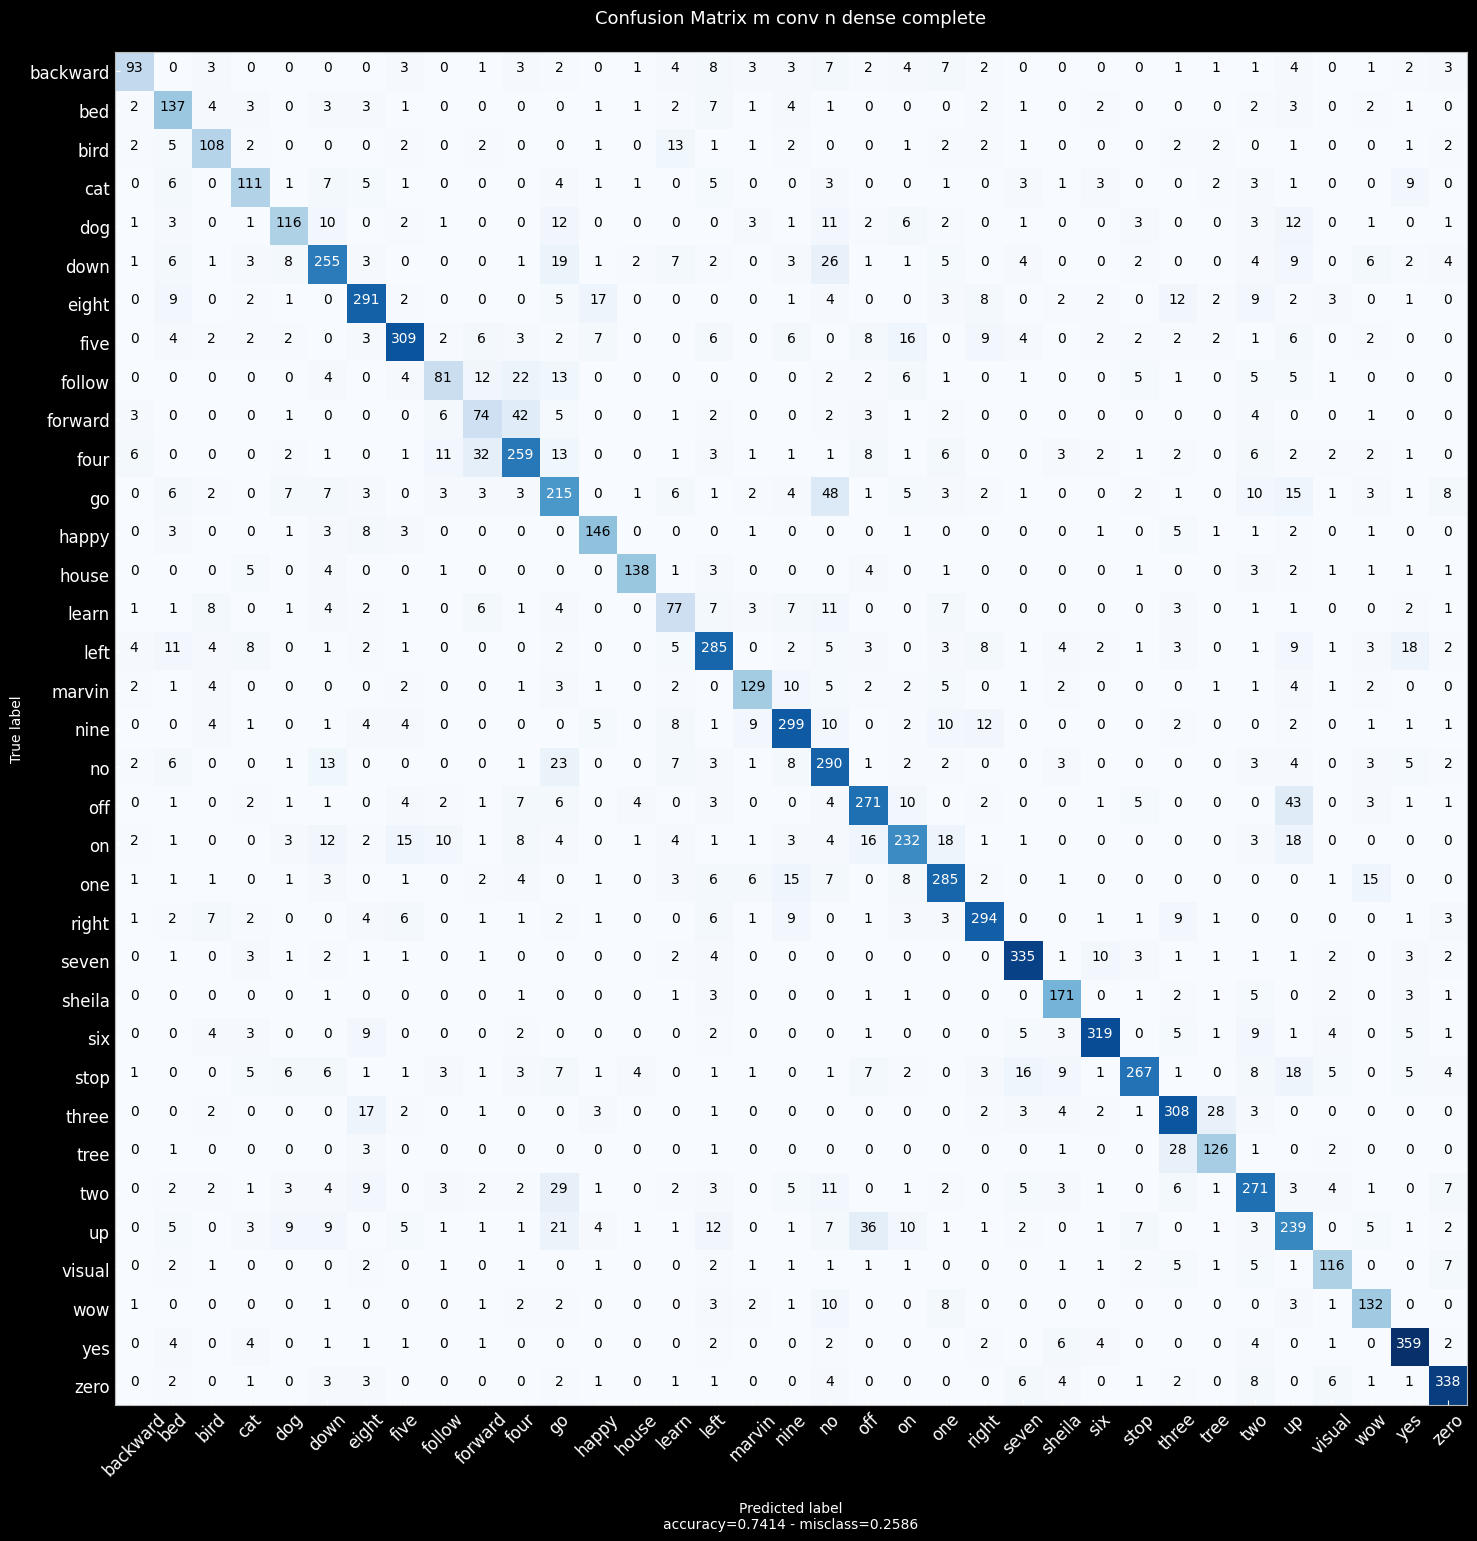

In [48]:
plot_confusion_matrix(matrix,
                      constants.labels_35_classes, 
                      title = "Confusion Matrix m conv n dense complete",
                      figsize = (15,15))

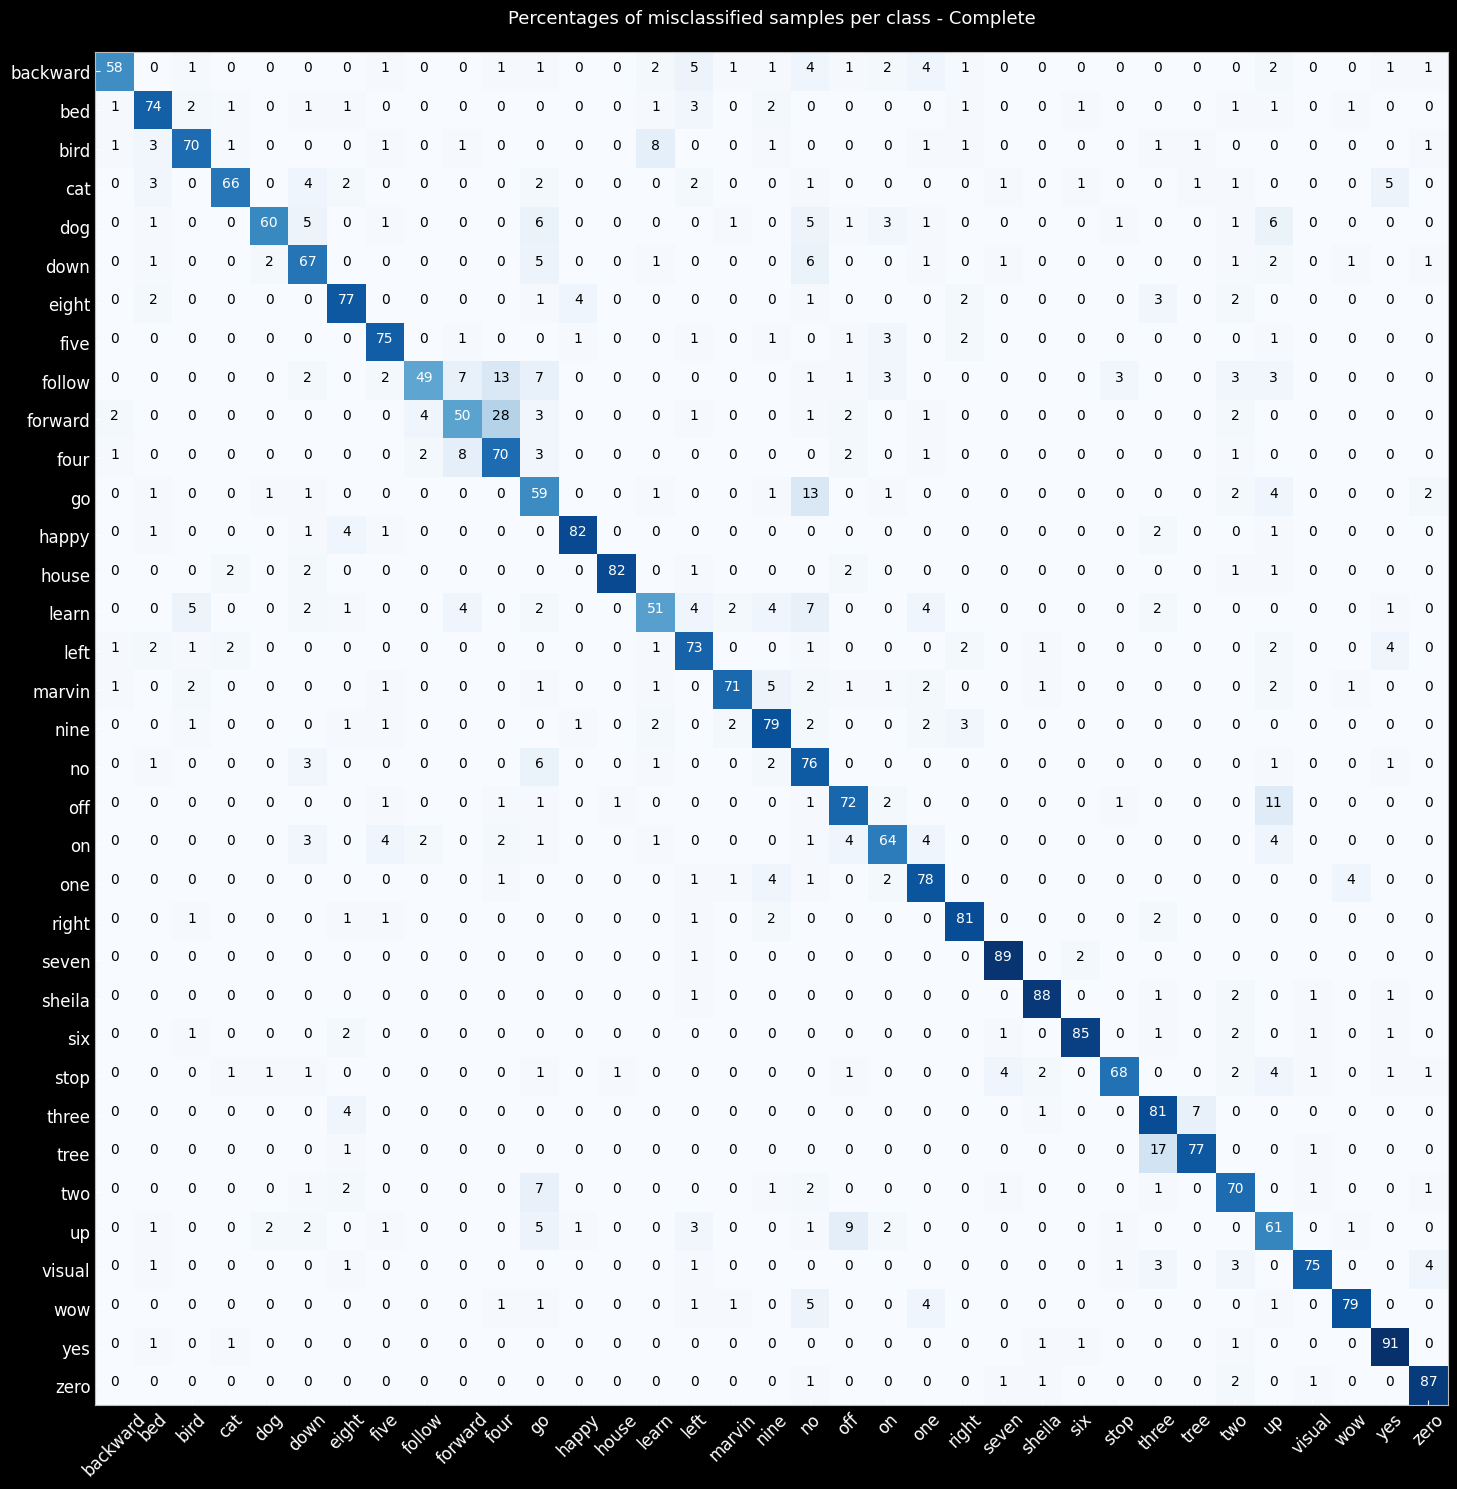

In [49]:
percentages_misclassified_samples = np.ones_like(matrix)

sums = np.sum(matrix, axis = 1)

for i in range(matrix.shape[0]):
    percentages_misclassified_samples[i] = matrix[i] / sums[i] * 100

# percentages_misclassified_samples
plot_confusion_matrix(percentages_misclassified_samples, 
                      constants.labels_35_classes, 
                      title = "Percentages of misclassified samples per class - Complete", 
                      display_metrics = False,
                      figsize = (15,15))

### Prediction Time of $\mathcal{M}^*$

In [50]:
starts = np.empty((len(X_test_envelope), ))
ends = np.empty((len(X_test_envelope), ))

In [51]:
for i in range(len(X_test_envelope)):

    a = np.array([X_test_envelope[i]])

    starts[i] = time.time()
    a = np.argmax(model.predict(a),1)
    ends[i] = time.time()

average = sum(ends-starts)/len(X_test_envelope)

print("Average single prediction time (ms):", 1000*average)

Average single prediction time (ms): 39.72554653749974


### Saving model

In [52]:
model.save('../models/best_m_conv2d_n_dense_complete_model.h5')

# [TO UPDATE] Things to consider in Training Neural Nets


The kind of scaling applied to data (this has effects only on the first layer of the net) 

The presence of batch-normalization 

Estimation of the variance of the model 

Estimation 

Weigths Initialization Scheme 

Property of constant variance and 0 mean of the activations across the layers

Assessing issues relating to mislead classifications 

Distribution of Activations in the net 

Gradient Clipping




Give examples of how different types of initializations can lead to different results
Examine the importance of initialization in complex neural networks
Explain the difference between train/dev/test sets
Diagnose the bias and variance issues in your model
Assess the right time and place for using regularization methods such as dropout or L2 regularization
Explain Vanishing and Exploding gradients and how to deal with them
Use gradient checking to verify the accuracy of your backpropagation implementation
Apply zeros initialization, random initialization, and He initialization
Apply regularization to a deep learning model

# Code to test functionalities


In [ ]:
toy_example = np.array([[[1,2,3],
                         [4,5,6],
                         [7,8,9]],
                        [[10,11,12],
                         [13,14,15],
                         [16,17,18]]])

In [ ]:
toy_example.shape

(2, 3, 3)

In [ ]:
np.max(toy_example) # every axis 

18

In [ ]:
np.max(toy_example, axis = 0) # point-wise maximum sample that c

array([[10, 11, 12],
       [13, 14, 15],
       [16, 17, 18]])

In [ ]:
np.max(toy_example,axis=1) # across columns

array([[ 7,  8,  9],
       [16, 17, 18]])

In [ ]:
np.max(toy_example,axis=2) # across rows

array([[ 3,  6,  9],
       [12, 15, 18]])

<AxesSubplot:ylabel='Count'>

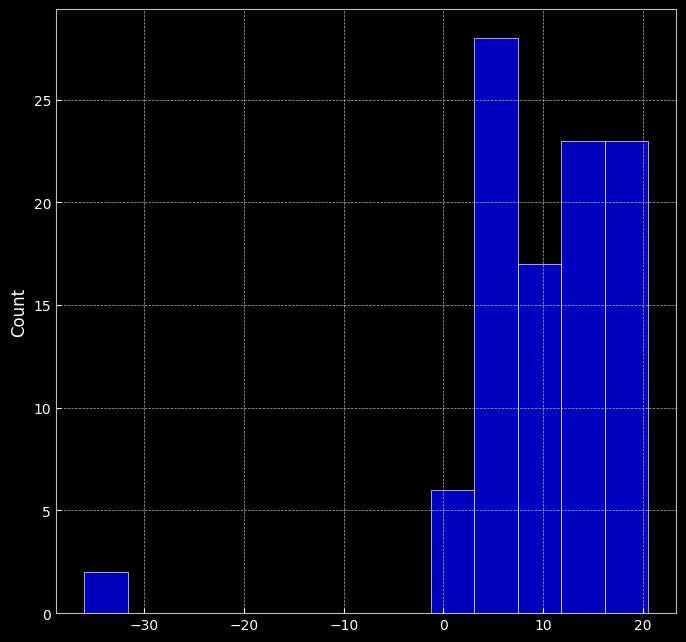

In [ ]:
sns.histplot(X_train[0][0])

In [ ]:
np.outer(np.max(np.max(X_train, axis = 2), axis = 0), np.ones((1,99))).shape

(40, 99)

(40, 99)

In [ ]:
X_train[0].shape

(40, 99)